### Libraries

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, RandomOverSampler 
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import display

# Models:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score, recall_score, precision_score

### Read The Data

In [39]:
try:
  df = pd.read_csv('Data/train_set.csv')
  test = pd.read_csv('Data/test_set.csv')
  sample_sub = pd.read_csv('Data/sub_example.csv')
except Exception:
  print('No such file or directory...')


In [40]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,380337,Male,30,1,28.0,1,< 1 Year,No,60954.0,152.0,127,0
1,282196,Male,26,1,6.0,1,< 1 Year,No,24532.0,152.0,216,0
2,60095,Male,40,1,0.0,0,1-2 Year,Yes,2630.0,47.0,220,0
3,124730,Male,25,1,8.0,1,< 1 Year,No,44259.0,152.0,223,0
4,474060,Female,26,1,28.0,1,< 1 Year,No,33615.0,152.0,194,0


In [41]:
test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,162946,Male,26,1,28.0,0,< 1 Year,Yes,26059.0,152.0,225
1,250469,Male,48,1,41.0,0,1-2 Year,No,43838.0,26.0,137
2,145870,Female,24,1,28.0,1,< 1 Year,No,56483.0,152.0,295
3,159515,Female,20,1,2.0,0,< 1 Year,No,33101.0,160.0,234
4,294257,Male,62,1,15.0,1,1-2 Year,No,35088.0,26.0,79


### Data Analysis

In [42]:
print('Train shape: ', df.shape)
print('Test shape: ', test.shape)

Train shape:  (305723, 12)
Test shape:  (76431, 11)


In [43]:
df.dtypes.value_counts()

int64      6
object     3
float64    3
dtype: int64

In [44]:
print('Object columns: \n', df.select_dtypes(include='object').columns.tolist())
print('Int64 columns: \n', df.select_dtypes(include='int64').columns.tolist())
print('Float64 columns: \n', df.select_dtypes(include='float64').columns.tolist())

Object columns: 
 ['Gender', 'Vehicle_Age', 'Vehicle_Damage']
Int64 columns: 
 ['id', 'Age', 'Driving_License', 'Previously_Insured', 'Vintage', 'Response']
Float64 columns: 
 ['Region_Code', 'Annual_Premium', 'Policy_Sales_Channel']


In [45]:
df1 = df.drop('id',axis=1)

In [46]:
df1.isnull().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [47]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,305723.0,38.527029,15.216020,20.0,25.0,36.0,49.0,85.0
Driving_License,305723.0,0.998106,0.043477,0.0,1.0,1.0,1.0,1.0
Region_Code,305723.0,26.427413,13.178366,0.0,15.0,28.0,35.0,52.0
Previously_Insured,305723.0,0.489878,0.499898,0.0,0.0,0.0,1.0,1.0
Annual_Premium,305723.0,30698.991479,17060.104811,2630.0,24533.5,31685.0,39425.0,540165.0
Policy_Sales_Channel,305723.0,111.927369,54.302872,1.0,26.0,145.0,152.0,163.0
Vintage,305723.0,154.317362,83.708893,10.0,82.0,154.0,227.0,299.0
Response,305723.0,0.163413,0.369742,0.0,0.0,0.0,0.0,1.0


In [48]:
df1.describe(include='O')

,Gender,Vehicle_Age,Vehicle_Damage
count,305723,305723,305723
unique,2,3,2
top,Male,1-2 Year,No
freq,164595,159977,158891


In [49]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305723 entries, 0 to 305722
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                305723 non-null  object 
 1   Age                   305723 non-null  int64  
 2   Driving_License       305723 non-null  int64  
 3   Region_Code           305723 non-null  float64
 4   Previously_Insured    305723 non-null  int64  
 5   Vehicle_Age           305723 non-null  object 
 6   Vehicle_Damage        305723 non-null  object 
 7   Annual_Premium        305723 non-null  float64
 8   Policy_Sales_Channel  305723 non-null  float64
 9   Vintage               305723 non-null  int64  
 10  Response              305723 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 25.7+ MB


array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Driving_License'}>,
        <AxesSubplot:title={'center':'Region_Code'}>],
       [<AxesSubplot:title={'center':'Previously_Insured'}>,
        <AxesSubplot:title={'center':'Annual_Premium'}>,
        <AxesSubplot:title={'center':'Policy_Sales_Channel'}>],
       [<AxesSubplot:title={'center':'Vintage'}>,
        <AxesSubplot:title={'center':'Response'}>, <AxesSubplot:>]],
      dtype=object)

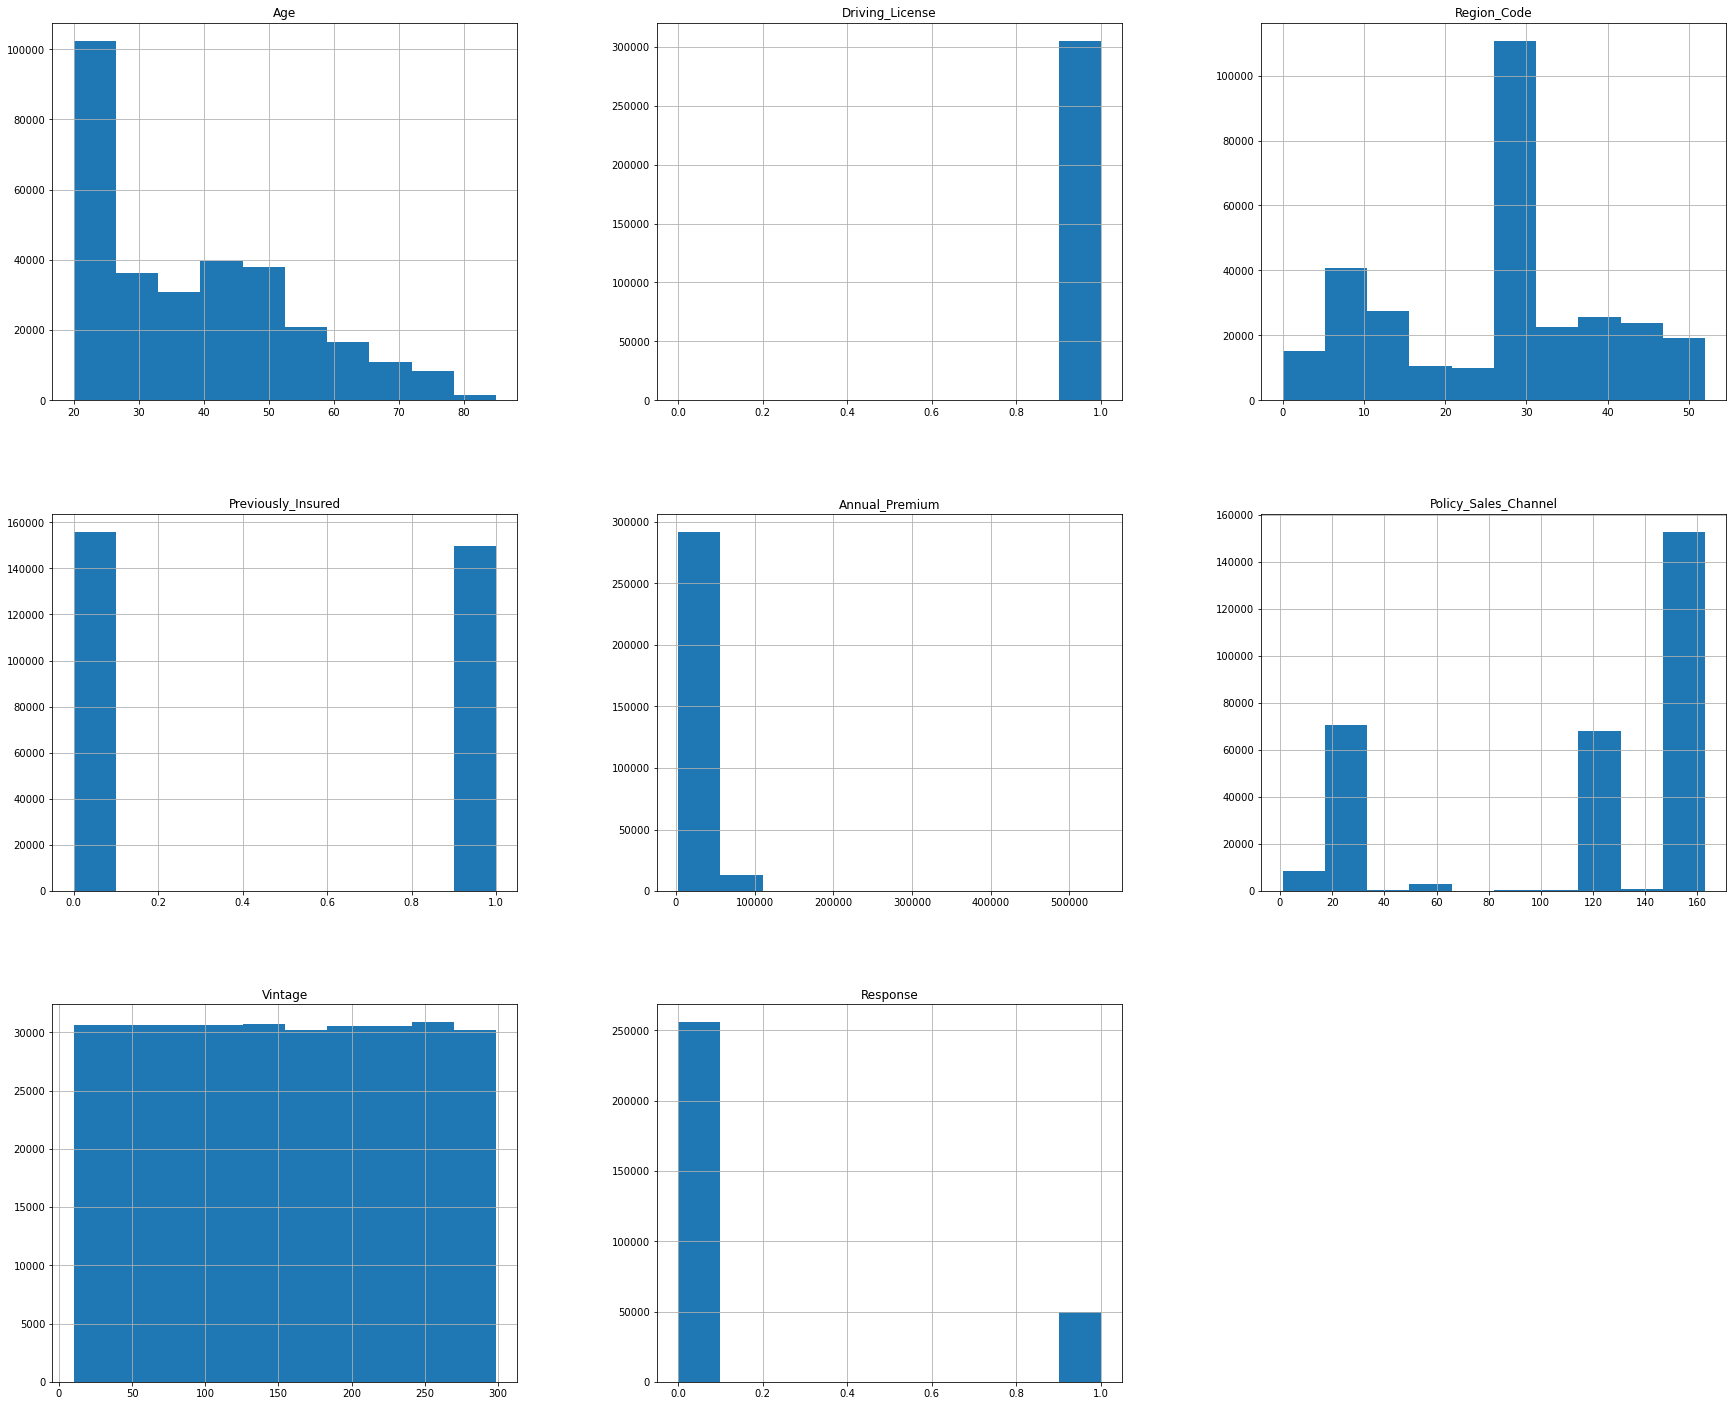

In [50]:
df1.drop(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], axis=1).hist(figsize=(30, 25), grid=True)

In [51]:
driving = df1[['Driving_License', 'Response']]
print('for Driving_License = 0:\n\n', driving[driving['Driving_License']==0]['Response'].value_counts())
print('=============================\nfor Driving_License = 1:\n\n', driving[driving['Driving_License']==1]['Response'].value_counts())

for Driving_License = 0:

 0    548
1     31
Name: Response, dtype: int64
for Driving_License = 1:

 0    255216
1     49928
Name: Response, dtype: int64


In [52]:
# df1 = df1.drop('Driving_License', axis=1)

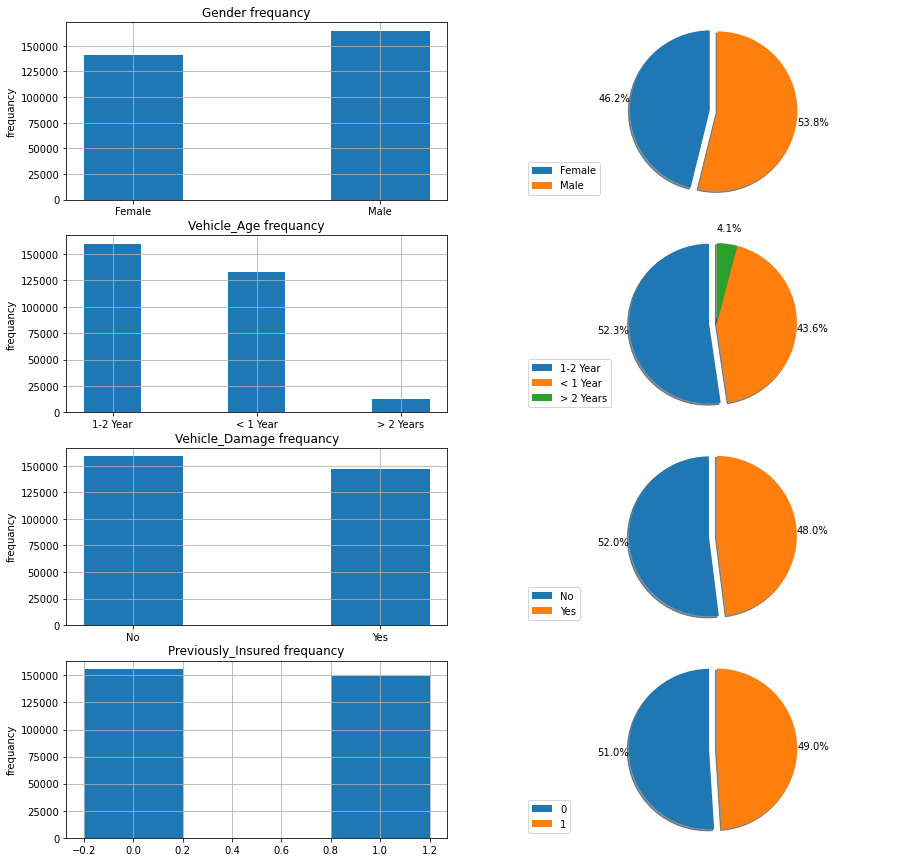

In [53]:
fig, ax = plt.subplots(4,2, figsize=(15,15))
explode = (0, 0.1, 0, 0)
for count, value in enumerate(['Gender', 'Vehicle_Age', 'Vehicle_Damage', 'Previously_Insured']):
    freq_table = pd.crosstab(index=df1[value], columns='frequancy')
    # visualize bar_plot
    ax[count, 0].bar(freq_table.index.tolist(), freq_table['frequancy'],  width=0.4)
    ax[count, 0].grid()
    ax[count, 0].set_title(str(value)+' frequancy')
    ax[count, 0].set_ylabel('frequancy')
    # visualize pie_plot
    sizes = np.array(freq_table['frequancy'].values.tolist())
    sizes = (sizes/len(df1))*100
    max_val = max(sizes)
    max_index = np.where(sizes == max_val)
    explode = tuple([0 if i!=max_index[0][0] else 0.1 for i in range(len(sizes))])
    ax[count, 1].pie(sizes, explode=explode, labels=None, pctdistance=1.2, autopct='%1.1f%%', shadow=True, startangle=90)
    ax[count, 1].legend(labels=freq_table['frequancy'].index, loc=3)
    ax[count, 1].axis('equal')
plt.savefig('Images/Categorical_features.jpeg')

In [54]:
print('The number of Region code unique value: ', df1.Region_Code.unique().size)

The number of Region code unique value:  53


Text(0.5, 1.0, 'Region Code')

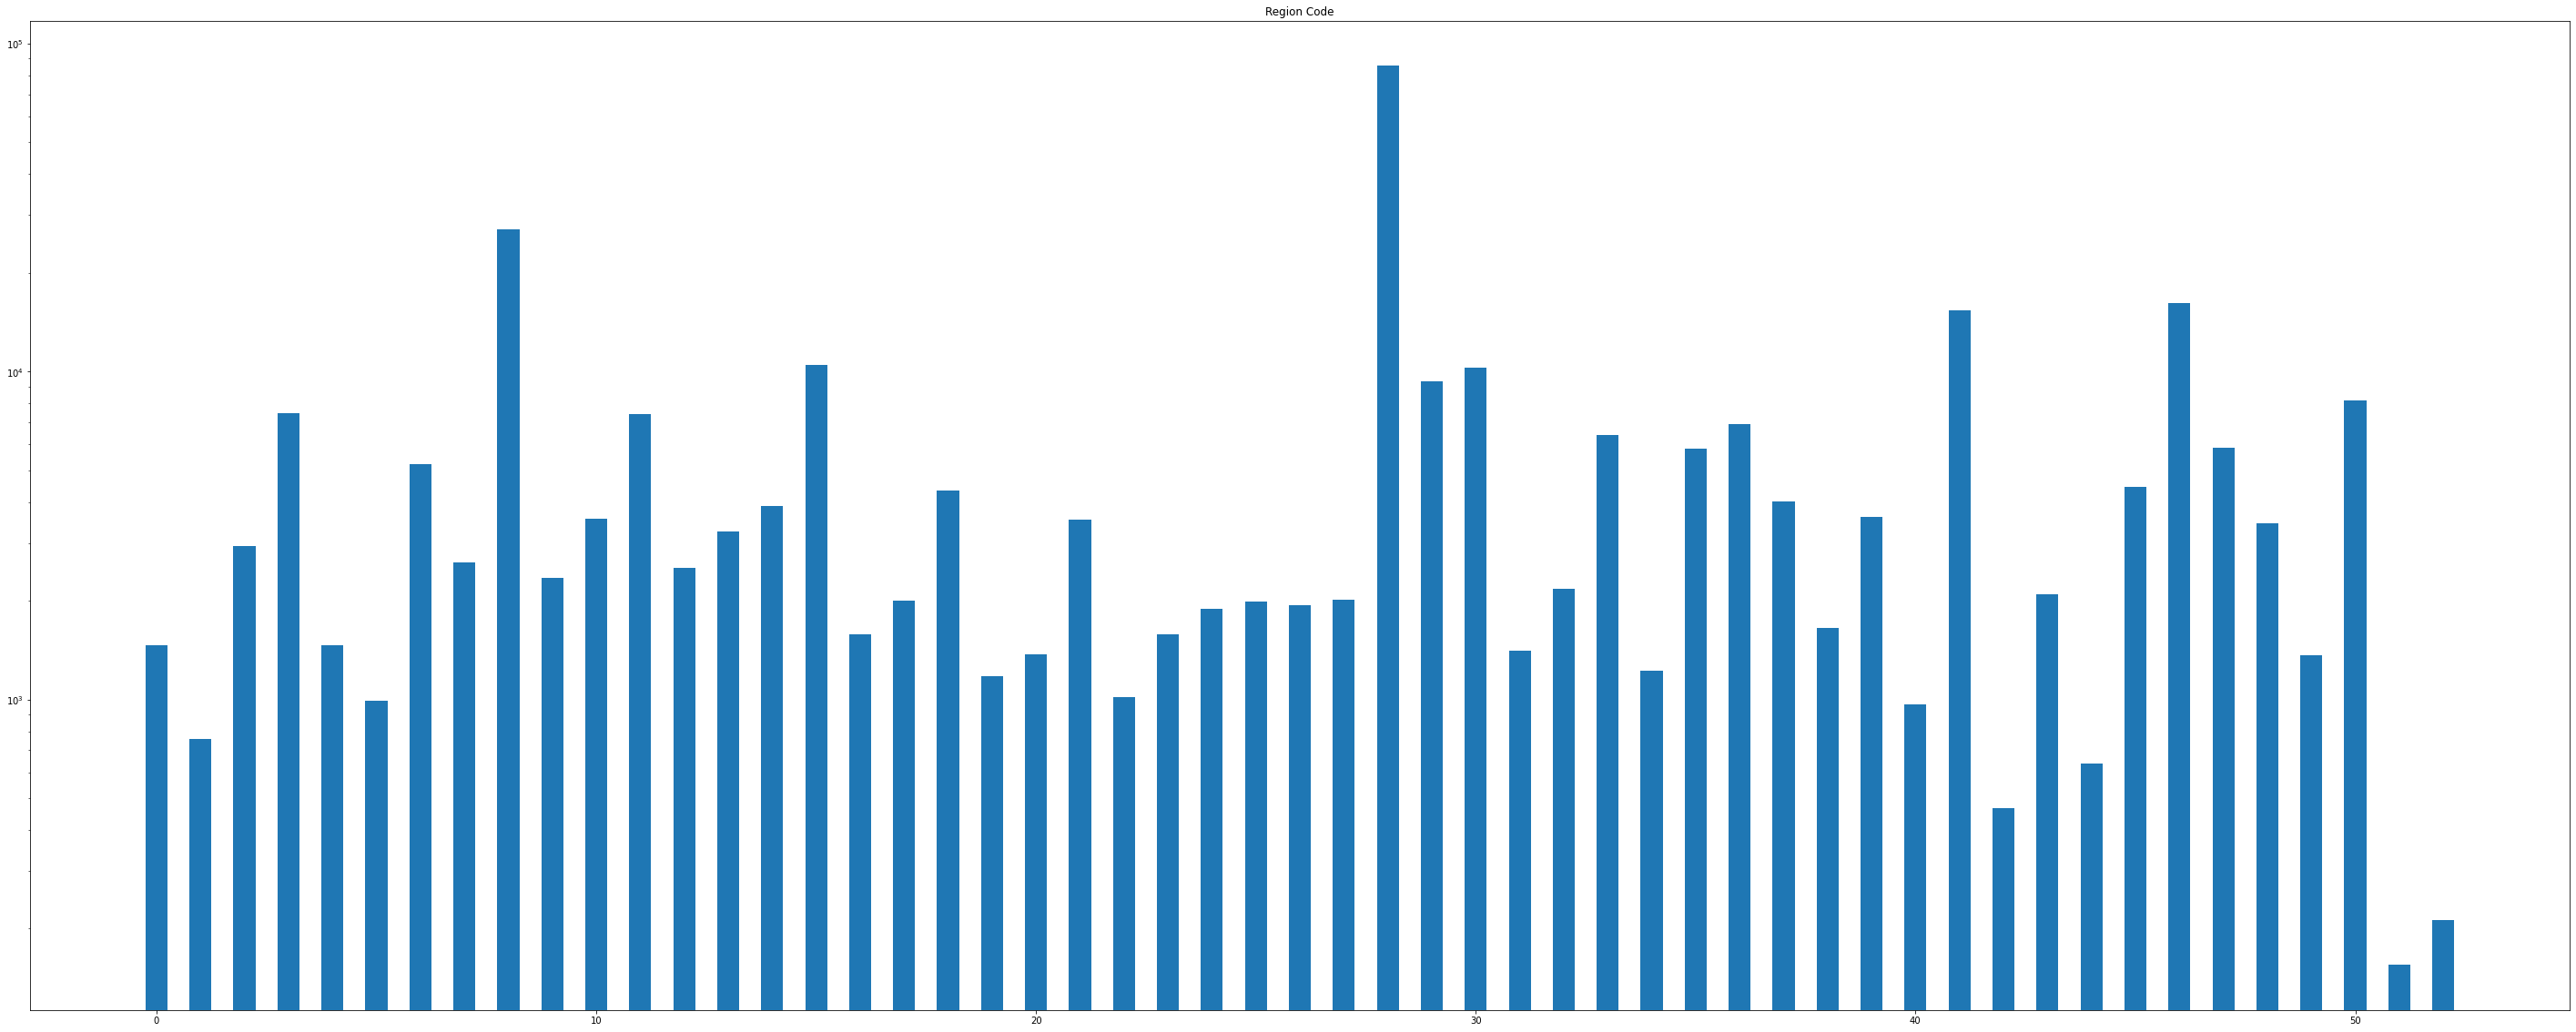

In [55]:
fig, ax = plt.subplots(figsize=(50, 20))
width = 0.50
counts = pd.DataFrame(df1.Region_Code.value_counts())
ax.bar(counts.index.tolist(), counts.Region_Code.tolist(), width, log=True)
ax.set_title('Region Code')

In [56]:
data = df1.copy()

In [57]:
data['Region_Code'] =data['Region_Code'].astype('int64')
data['Policy_Sales_Channel'] =data['Policy_Sales_Channel'].astype('int64')

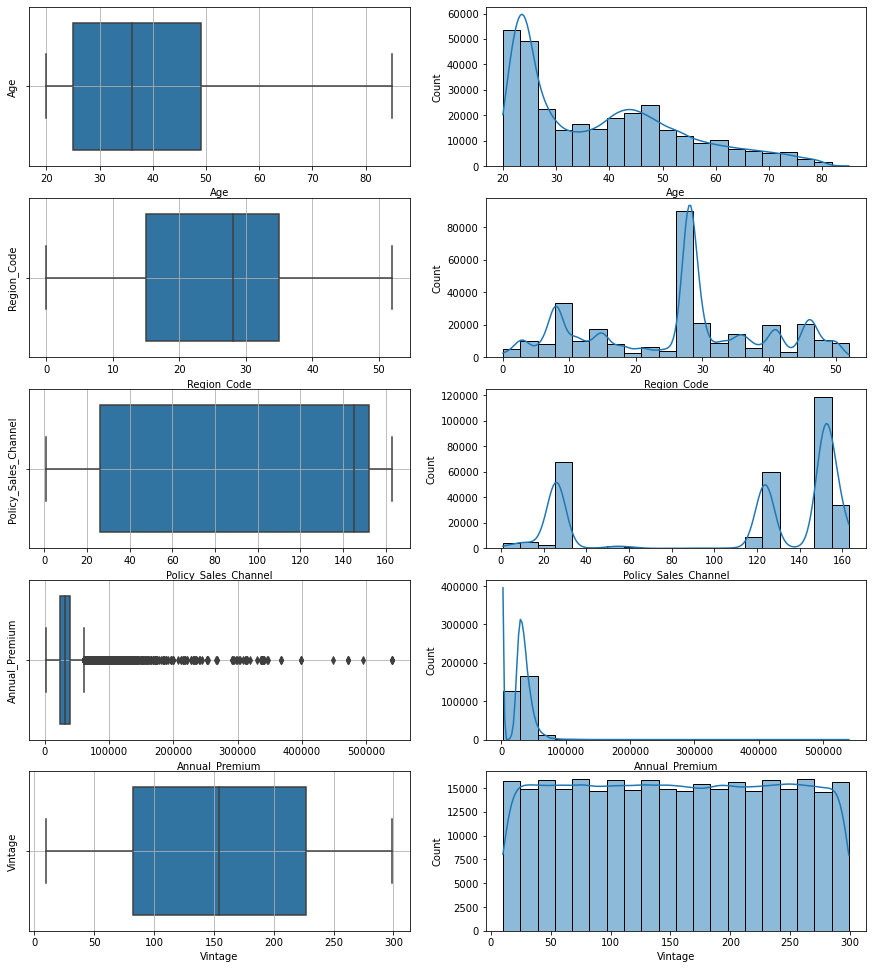

In [58]:
fig, ax = plt.subplots(5,2, figsize=(15,17))
for count1, value in enumerate(['Age', 'Region_Code', 'Policy_Sales_Channel', 'Annual_Premium', 'Vintage']):
    # visulaize box plot
    sns.boxplot(data=data, x=data[value], ax=ax[count1, 0])
    ax[count1, 0].set_ylabel(str(value))
    ax[count1, 0].grid()
    # visulaize histogram plot
    bins = len(data[value].unique())//2
    sns.histplot(data=data, x=data[value], bins=20, kde=True, ax=ax[count1, 1])
plt.savefig('Images/Numerical_Features.jpeg')

In [59]:
print('The number of Policy Sales Channel unique value: ',data.Policy_Sales_Channel.unique().size)

The number of Policy Sales Channel unique value:  156


In [60]:
temp_df = data[['Response', 'Policy_Sales_Channel']]
temp_x = set(temp_df[temp_df.Response == 0]['Policy_Sales_Channel'].unique())
temp_y = set(temp_df[temp_df.Response == 1]['Policy_Sales_Channel'].unique())
list(temp_x-temp_y)
list(temp_y-temp_x)
print(list(temp_x.intersection(temp_y)))

[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 35, 36, 37, 38, 39, 42, 44, 45, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 73, 78, 80, 81, 86, 87, 88, 89, 90, 91, 92, 93, 94, 98, 101, 103, 106, 107, 109, 110, 111, 113, 114, 116, 119, 120, 121, 122, 124, 125, 127, 128, 129, 130, 131, 132, 133, 135, 136, 138, 139, 140, 145, 147, 148, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 163]


In [61]:
print('The number of Vintage unique value: ', len(data.Vintage.unique()))
print(data.Vintage.value_counts())

The number of Vintage unique value:  290
73     1143
144    1142
31     1141
256    1133
42     1131
       ... 
97      978
118     978
32      976
277     972
224     961
Name: Vintage, Length: 290, dtype: int64


### Remove the outliers using IQR

In [62]:
Q1 = data.Annual_Premium.quantile(0.25)
Q3 = data.Annual_Premium.quantile(0.75)
IQR = Q3 - Q1
maxi = (1.5 * IQR) + Q3
print('The number of outliers in Annaul_Premium: ', data[data.Annual_Premium > maxi].shape[0])

The number of outliers in Annaul_Premium:  8334


In [63]:
continuous_features = ['Age', 'Region_Code', 'Policy_Sales_Channel', 'Vintage', 'Annual_Premium']
def detect_outLier_features(df):
    for feature in continuous_features:
        q1 = np.quantile(df[feature], 0.25, interpolation='midpoint')
        q3 = np.quantile(df[feature], 0.75, interpolation='midpoint')
        IQR = q3 - q1
        upper_outlier = q3 + (1.5 * IQR)
        lower_outlier = q1 - (1.5 * IQR)
        print(str(feature)+' IQR :', IQR)
        print(str(feature)+' Upper Outlier :', upper_outlier)
        print(str(feature)+' Lower Outlier :', lower_outlier)
        print('==============================================')
detect_outLier_features(data)

Age IQR : 24.0
Age Upper Outlier : 85.0
Age Lower Outlier : -11.0
Region_Code IQR : 20.0
Region_Code Upper Outlier : 65.0
Region_Code Lower Outlier : -15.0
Policy_Sales_Channel IQR : 126.0
Policy_Sales_Channel Upper Outlier : 341.0
Policy_Sales_Channel Lower Outlier : -163.0
Vintage IQR : 145.0
Vintage Upper Outlier : 444.5
Vintage Lower Outlier : -135.5
Annual_Premium IQR : 14891.5
Annual_Premium Upper Outlier : 61762.25
Annual_Premium Lower Outlier : 2196.25


In [64]:
cols = list(data[continuous_features])
Q1 = data[cols].quantile(0.25)
Q3 = data[cols].quantile(0.75)
IQR = Q3 - Q1
condition = ~((data[cols] < (Q1 - 1.5 * IQR)) | (data[cols] > (Q3 + 1.5 * IQR))).any(axis=1)
data = data[condition]

In [65]:
data.shape

(297389, 11)

<AxesSubplot:xlabel='Annual_Premium', ylabel='Count'>

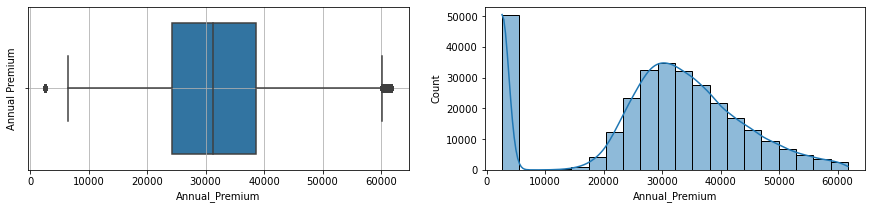

In [66]:
fig, ax = plt.subplots(1,2, figsize=(15,3))
# visulaize box plot
sns.boxplot(data=data, x=data.Annual_Premium, ax=ax[0])
ax[0].set_ylabel('Annual Premium')
ax[0].grid()
# visulaize histogram plot
bins = len(data.Annual_Premium.unique())//2
sns.histplot(data=data, x=data.Annual_Premium, bins=20, kde=True, ax=ax[1])

In [67]:
# data = data[data.Annual_Premium>7000]
# fig, ax = plt.subplots(1,2, figsize=(15,3))
# # visulaize box plot
# sns.boxplot(data=data, x=data.Annual_Premium, ax=ax[0])
# ax[0].set_ylabel('Annual Premium')
# ax[0].grid()
# # visulaize histogram plot
# bins = len(data.Annual_Premium.unique())//2
# sns.histplot(data=data, x=data.Annual_Premium, bins=20, kde=True, ax=ax[1])

In [68]:
print(data.shape)
data.isnull().sum()

(297389, 11)


Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [69]:
Target = data['Response']
data = data.drop('Response',axis=1)

### Encoder

In [70]:
## male => 0 
## Female => 1 
data['Gender'] = data['Gender'].map({'Male': 0,'Female': 1})

In [71]:
# No => 0
# Yes => 1
data['Vehicle_Damage'] = data['Vehicle_Damage'].map({'No': 0,'Yes': 1})

In [72]:
# < 1 Year => 1
# 1-2 Year => 2
# > 2 Years => 3 
data['Vehicle_Age'] = data['Vehicle_Age'].map({'< 1 Year': 1,'1-2 Year': 2,'> 2 Years':3})

In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297389 entries, 0 to 305722
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                297389 non-null  int64  
 1   Age                   297389 non-null  int64  
 2   Driving_License       297389 non-null  int64  
 3   Region_Code           297389 non-null  int64  
 4   Previously_Insured    297389 non-null  int64  
 5   Vehicle_Age           297389 non-null  int64  
 6   Vehicle_Damage        297389 non-null  int64  
 7   Annual_Premium        297389 non-null  float64
 8   Policy_Sales_Channel  297389 non-null  int64  
 9   Vintage               297389 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 25.0 MB


In [74]:
discrete_features = ['Gender', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage']

### Correlations

In [75]:
Target.value_counts()

0    249079
1     48310
Name: Response, dtype: int64

The Target Variable


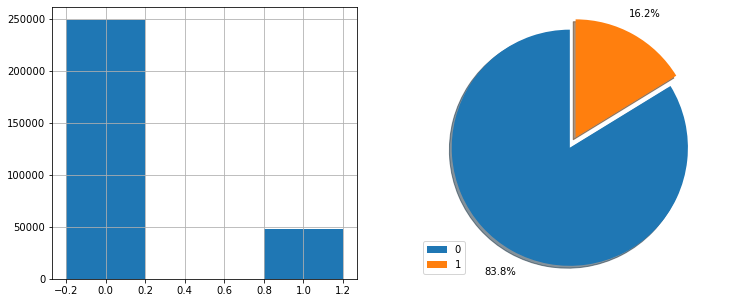

In [76]:
print('The Target Variable')
fig, ax = plt.subplots(1,2,figsize=(12,5))
freq_table = pd.crosstab(index=Target, columns='frequancy')
# visualize bar_plot
ax[0].bar(freq_table.index.tolist(), freq_table['frequancy'],  width=0.4)
ax[0].grid()
# visualize pie_plot
sizes = np.array(freq_table['frequancy'].values.tolist())
sizes = (sizes/len(Target))*100
max_val = max(sizes)
max_index = np.where(sizes == max_val)
explode = tuple([0 if i!=max_index[0][0] else 0.1 for i in range(len(sizes))])
ax[1].pie(sizes, explode=explode, labels=None, pctdistance=1.2, autopct='%1.1f%%', shadow=True, startangle=90)
ax[1].legend(labels=freq_table['frequancy'].index, loc=3)
ax[1].axis('equal')
plt.savefig('Images/Target_feature.jpeg')

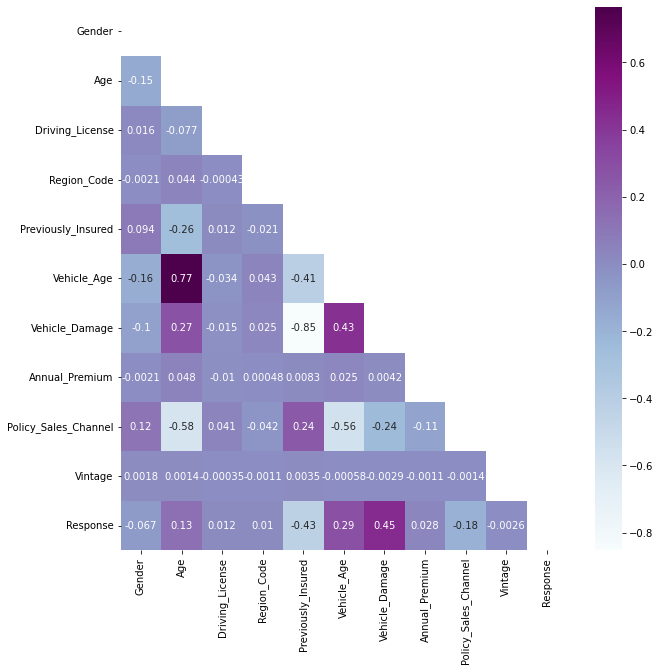

In [78]:
fig, ax = plt.subplots(figsize=(10,10))
corr = pd.concat([data, Target], axis=1).corr()
matrix = np.triu(corr)
sns.heatmap(corr,
        xticklabels=corr.columns,
        yticklabels=corr.columns,annot=True, cmap="BuPu", mask=matrix)
plt.savefig('Images/Correlation.jpeg')

In [41]:
# The correlation between Region_code and Response
# Weak correlation -> 0.189
def Cramers_V(data):
    X2 = stats.chi2_contingency(data, correction=False)[0]
    n = np.sum(data)
    minDim = min(data.shape)-1
    V = np.sqrt((X2/n) / minDim)
    print('The Result: ',V)
Temp_df = pd.concat([data['Region_Code'], Target],axis=1)
Temp_df = pd.crosstab(Temp_df['Region_Code'],Temp_df['Response']).to_numpy()
Cramers_V(Temp_df)

The Result:  0.18926508012198684


In [42]:
# The correlation between Gender and Response
# There is a correlation
def Chi_square(data):
    stat, P_val = stats.chi2_contingency(data, correction=False)[:2]
    print('P_value = {0:.5f}'.format(P_val))
Temp_df = pd.concat([data['Gender'], Target],axis=1)
Temp_df = pd.crosstab(Temp_df['Gender'],Temp_df['Response']).to_numpy()
Chi_square(Temp_df)

P_value = 0.00000


In [43]:
# The correlation between Annual_Premium and Response
# There is no correlation
def Point_biserial(data):
    cat = data['Response'].to_numpy()
    con = data['Annual_Premium'].to_numpy()
    R_value, P_value = stats.pointbiserialr(cat, con)
    print('The R_value = {0:.3f}'.format(R_value))
    print('The P_value = {0:.3f}'.format(P_value))
Temp_df = pd.concat([data['Annual_Premium'], Target],axis=1)
Point_biserial(Temp_df)

The R_value = 0.028
The P_value = 0.000


In [44]:
# smt=SMOTETomek(sampling_strategy='auto')
# smt.fit(data, Target)
# X_resampled, y_resampled = smt.fit_resample(data, Target)

In [45]:
# smt=SMOTEENN(random_state=42)
# smt.fit(data, Target)
# X_resampled, y_resampled = smt.fit_resample(data, Target)

In [46]:
# print('The Target after Resampling: ', y_resampled.shape)
# print('The Features after Resampling: ', X_resampled.shape)

In [47]:
# print('The Target Variable')
# fig, ax = plt.subplots(1,2,figsize=(12,5))
# freq_table = pd.crosstab(index=y_resampled, columns='frequancy')
# # visualize bar_plot
# ax[0].bar(freq_table.index.tolist(), freq_table['frequancy'],  width=0.4)
# ax[0].grid()
# # visualize pie_plot
# sizes = np.array(freq_table['frequancy'].values.tolist())
# sizes = (sizes/len(Target))*100
# max_val = max(sizes)
# max_index = np.where(sizes == max_val)
# explode = tuple([0 if i!=max_index[0][0] else 0.1 for i in range(len(sizes))])
# ax[1].pie(sizes, explode=explode, labels=None, pctdistance=1.2, autopct='%1.1f%%', shadow=True, startangle=90)
# ax[1].legend(labels=freq_table['frequancy'].index, loc=3)
# ax[1].axis('equal')

In [48]:
# fig, ax = plt.subplots(figsize=(10,10))
# corr = pd.concat([y_resampled, X_resampled], axis=1).corr()
# matrix = np.triu(corr)
# sns.heatmap(corr,
#         xticklabels=corr.columns,
#         yticklabels=corr.columns,annot=True, cmap="BuPu", mask=matrix)
# plt.show()

In [49]:
data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,0,30,1,28,1,1,0,60954.0,152,127
1,0,26,1,6,1,1,0,24532.0,152,216
2,0,40,1,0,0,2,1,2630.0,47,220
3,0,25,1,8,1,1,0,44259.0,152,223
4,1,26,1,28,1,1,0,33615.0,152,194


In [50]:
X_resampled =data.copy()
# drop(['Vintage','Region_Code', 'Age','Driving_License','Annual_Premium','Previously_Insured'],axis=1)

In [51]:
X_resampled.shape

(297389, 10)

### Scaling

In [52]:
scale = MinMaxScaler().fit(X_resampled)
features = scale.transform(X_resampled)
features

array([[0.        , 0.15384615, 1.        , ..., 0.98633566, 0.93209877,
        0.40484429],
       [0.        , 0.09230769, 1.        , ..., 0.37039167, 0.93209877,
        0.71280277],
       [0.        , 0.30769231, 1.        , ..., 0.        , 0.28395062,
        0.7266436 ],
       ...,
       [0.        , 0.76923077, 1.        , ..., 0.51040046, 0.15432099,
        0.59861592],
       [0.        , 0.32307692, 1.        , ..., 0.47694987, 0.75925926,
        0.01384083],
       [0.        , 0.35384615, 1.        , ..., 0.64680714, 0.75925926,
        0.40484429]])

### Split and test models

In [53]:
train, valid, target, valid_target = train_test_split(features, Target, test_size = 0.25, random_state=42)

In [54]:
def classi_repo(valid_target, pred, model_name):
    print(model_name+':')
    print('F1-Score: ', f1_score(valid_target, pred))
    print('ROC_AUC_score: ', roc_auc_score(valid_target, pred), '\n\n')
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
    clf_report = classification_report(valid_target,
                                   pred,
                                   output_dict=True)
    g = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap='Blues', ax=ax1)
    g.set_title('Classification Report\n\n');
    #=========================================
    cf_matrix = confusion_matrix(valid_target, pred)
    g1 = sns.heatmap(cf_matrix, annot=True, cmap='Blues',ax=ax2)
    g1.set_title('Confusion Matrix\n\n');
    g1.set_xlabel('\nPredicted Values')
    g1.set_ylabel('Actual Values ');
    g1.xaxis.set_ticklabels(['False','True'])
    g1.yaxis.set_ticklabels(['False','True'])
    
    plt.show()

#### Random Forest Classifier

In [55]:
# weights = {0:0.162, 1:0.838}
# ran = RandomForestClassifier(class_weight=weights)
# ran.fit(train, target)
# ran_pre = ran.predict(valid)
# print('Random Forest predictions: ', ran_pre)

In [56]:
# classi_repo(valid_target, ran_pre, 'Random Forest Classifier')

#### LightGBM Classifier

In [57]:
# lgbm = lightgbm.LGBMClassifier(random_state=42, class_weight='balanced')
# lgbm.fit(train, target)
# lgbm_pre = lgbm.predict(valid)
# print('LightGBM predictions: ', lgbm_pre)

In [58]:
# display(classi_repo(valid_target, lgbm_pre, 'LightGBM Classifier'))

####  XGBClassifier

In [59]:
xgb = XGBClassifier(random_state=42, use_label_encoder=False)
xgb.fit(train, target)
xgb_pre = xgb.predict(valid)
print('XGBClassifier predictions: ', xgb_pre)

[23:45:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier predictions:  [0 0 0 ... 0 0 0]


XGBClassifier:
F1-Score:  0.4574813682400153
ROC_AUC_score:  0.666212400841381 




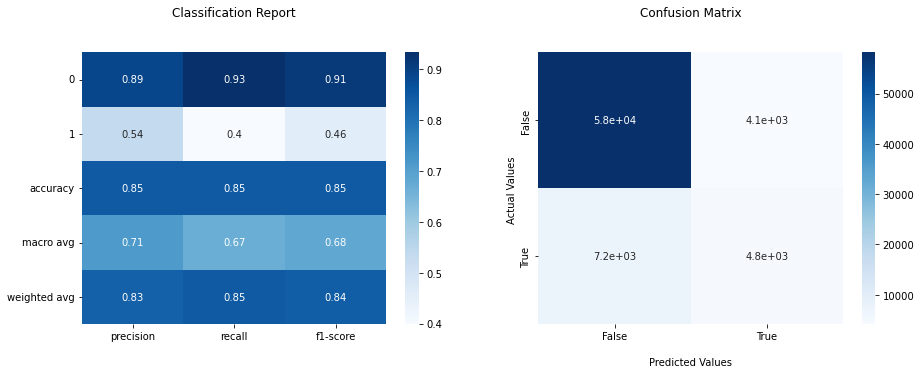

In [60]:
classi_repo(valid_target, xgb_pre, 'XGBClassifier')

### Tuning The Model & Resampling

#### LightGBM Classifier

In [61]:
# features = pd.DataFrame(features)
# f1_list = []
# param_test ={'num_leaves': sp_randint(6, 50), 
#              'min_child_samples': sp_randint(100, 500), 
#              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#              'subsample': sp_uniform(loc=0.2, scale=0.8), 
#              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
#              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
#              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}
# clf = lightgbm.LGBMClassifier(random_state=42)
# fold = KFold(n_splits=5, shuffle=True, random_state=42)
# gs = RandomizedSearchCV(
#     estimator=clf, param_distributions=param_test, 
#     n_iter=50,
#     scoring='f1',
#     cv=3,
#     random_state=42,
#     verbose=2, n_jobs = -1)
# for count, (train_index, val_index) in enumerate(fold.split(X=features, y=Target)):
#     print('Fold number ', count, ': ')
#     x_train, x_val = features.iloc[train_index], features.iloc[val_index]
#     y_train, y_val = Target.iloc[train_index], Target.iloc[val_index]
#     pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), gs)
#     model = pipeline.fit(x_train, y_train)
#     best_est = gs.best_estimator_
#     pred = best_est.predict(x_val)
#     f1_list.append(f1_score(y_val, pred))
# print("f1: {}".format(np.mean(f1_list)))

#### Random Forest Classifier

Fold number  1 : 
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Fold Number 1:
F1-Score:  0.49397203022022185
ROC_AUC_score:  0.700952746710644 




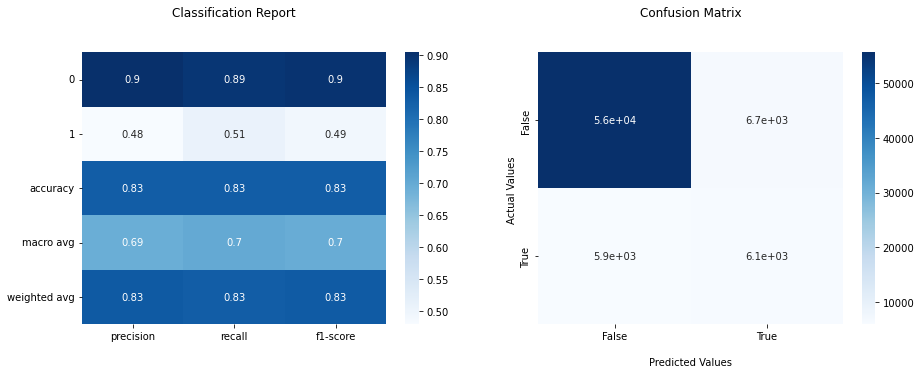

None

Fold number  2 : 
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Fold Number 2:
F1-Score:  0.492860877609299
ROC_AUC_score:  0.7001822517428802 




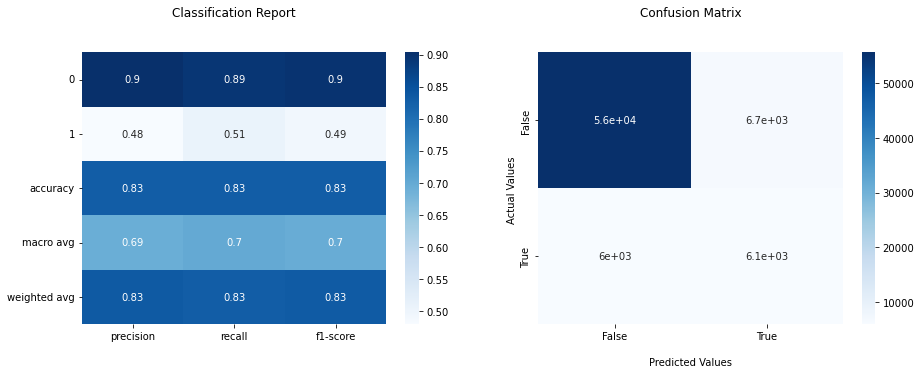

None

Fold number  3 : 
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Fold Number 3:
F1-Score:  0.4936329887030458
ROC_AUC_score:  0.7014406159226311 




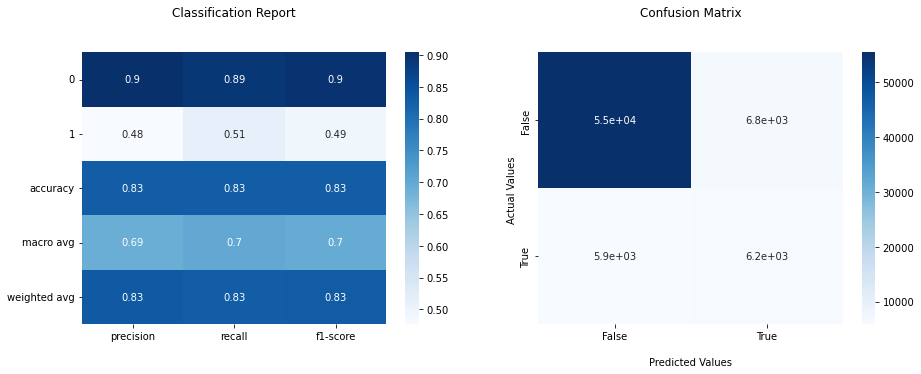

None

Fold number  4 : 
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Fold Number 4:
F1-Score:  0.4935755427558707
ROC_AUC_score:  0.7004713154974972 




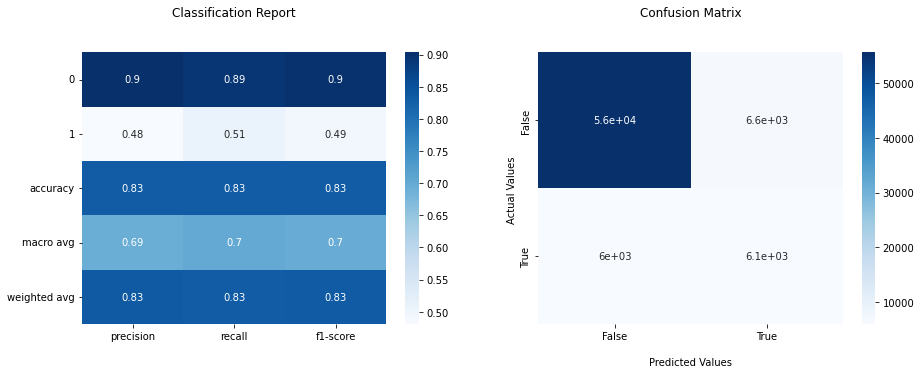

None

Fold number  5 : 
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Fold Number 5:
F1-Score:  0.4982835911312144
ROC_AUC_score:  0.703077205221358 




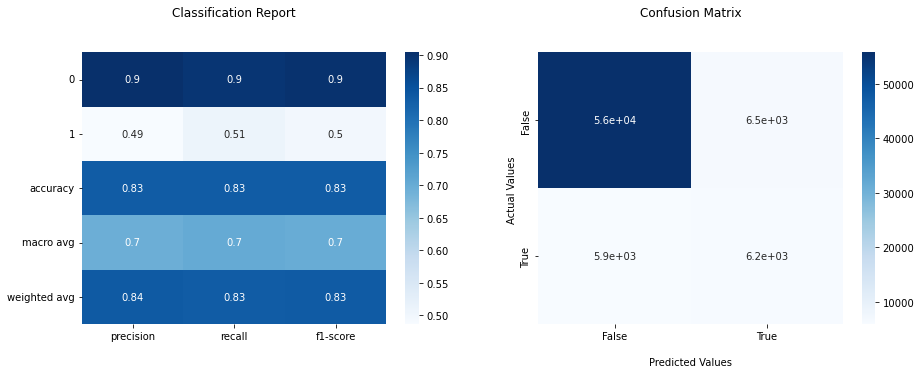

None

f1: 0.49446500608393035
auc: 0.7012248270190021


In [62]:
features = pd.DataFrame(features)
f1_list = []
roc_auc = []
n_estimators = [100]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 60, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
param_test ={'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
fold = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=1)
clf = RandomForestClassifier(random_state=1)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=10,
    cv=2,
    random_state=42,
    verbose=2, n_jobs = -1)
for count, (train_index, val_index) in enumerate(fold.split(X=features, y=Target)):
    print('Fold number ', count+1, ': ')
    x_train, x_val = features.iloc[train_index], features.iloc[val_index]
    y_train, y_val = Target.iloc[train_index], Target.iloc[val_index]
    
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'),gs)
    model = pipeline.fit(x_train, y_train)
    
    best_est = gs.best_estimator_
    pred = best_est.predict(x_val)
    display(classi_repo(y_val, pred, 'Fold Number '+str(count+1)))

    f1_list.append(f1_score(y_val, pred))
    roc_auc.append(roc_auc_score(y_val, pred))
print("f1: {}".format(np.mean(f1_list)))
print("auc: {}".format(np.mean(roc_auc)))

#### AdaBoost Classifier

In [63]:
# features = pd.DataFrame(features)
# f1_list = []
# param_test ={'n_estimators': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 20],
#     'learning_rate': [(0.97 + x / 100) for x in range(0, 8)],
#     'algorithm': ['SAMME', 'SAMME.R']}
# clf = AdaBoostClassifier(random_state=42)
# fold = KFold(n_splits=5, shuffle=True, random_state=42)
# gs = RandomizedSearchCV(
#     estimator=clf, param_distributions=param_test, 
#     n_iter=50,
#     scoring='f1',
#     cv=3,
#     random_state=42,
#     verbose=2, n_jobs = -1)
# for count, (train_index, val_index) in enumerate(fold.split(X=features, y=Target)):
#     print('Fold number ', count, ': ')
#     x_train, x_val = features.iloc[train_index], features.iloc[val_index]
#     y_train, y_val = Target.iloc[train_index], Target.iloc[val_index]
#     pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), gs)
#     model = pipeline.fit(x_train, y_train)
#     best_est = gs.best_estimator_
#     pred = best_est.predict(x_val)
#     f1_list.append(f1_score(y_val, pred))
# print("f1: {}".format(np.mean(f1_list)))

#### XGboost Classifier

In [64]:
# features = pd.DataFrame(features)
# accuracy_list = []
# precision_list = []
# recall_list = []
# f1_list = []
# roc_auc = []
# param_test ={'learning_rate':[0.01, 0.05, 0.1, 0.15, 0.2],
#             'n_estimators':[40, 60, 80],
#             'max_depth':[5,7,9,11,13,15],
#             'min_samples_split':list(range(1000,2100,200)),
#             'min_samples_leaf':[30,40,50,60],
#             'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
# clf = GradientBoostingClassifier(random_state=42)
# fold = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
# gs = RandomizedSearchCV(
#     estimator=clf, param_distributions=param_test, 
#     n_iter=30,
#     cv=3,
#     random_state=42,
#     verbose=2, n_jobs = -1)
# for count, (train_index, val_index) in enumerate(fold.split(X=features, y=Target)):
#     print('Fold number ', count+1, ': ')
#     x_train, x_val = features.iloc[train_index], features.iloc[val_index]
#     y_train, y_val = Target.iloc[train_index], Target.iloc[val_index]
    
#     pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'),gs)
#     model = pipeline.fit(x_train, y_train)
    
#     best_est = gs.best_estimator_
#     pred = best_est.predict(x_val)
    
#     # accuracy_list.append(pipeline.score(y_val, pred))
#     precision_list.append(precision_score(y_val, pred))
#     recall_list.append(recall_score(y_val, pred))
#     f1_list.append(f1_score(y_val, pred))
#     roc_auc.append(roc_auc_score(y_val, pred))

# # print("accurecy: {}".format(np.mean(accuracy_list)))
# print("precision: {}".format(np.mean(precision_list)))
# print("recall: {}".format(np.mean(recall_list)))
# print("f1: {}".format(np.mean(f1_list)))
# print("auc: {}".format(np.mean(roc_auc)))

In [65]:
# features = pd.DataFrame(features)
# accuracy_list = []
# precision_list = []
# recall_list = []
# f1_list = []
# roc_auc = []
# grid_param = {}
# param_test = {'eval_metric':['auc'],
#               'learning_rate':[0.01, 0.05, 0.1, 0.15, 0.2],
#               'n_estimators':[40, 60, 80, 100],
#               'max_depth':range(3,10,2),
#               'min_child_weight':[4,6,8,10,12],
#               'gamma':[i/10.0 for i in range(0,5)],
#               'subsample':[i/10.0 for i in range(6,10)],
#               'colsample_bytree':[i/10.0 for i in range(6,10)],
#               'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}
# clf = XGBClassifier(random_state=42, use_label_encoder=False)
# fold = StratifiedShuffleSplit(n_splits=3, test_size=0.25, random_state=42)
# gs = RandomizedSearchCV(
#     estimator=clf, param_distributions=param_test, 
#     n_iter=10,
#     scoring='roc_auc',
#     cv=3,
#     random_state=42,
#     verbose=2, n_jobs = -1)

# for count, (train_index, val_index) in enumerate(fold.split(X=features, y=Target)):
#     print('Fold number ', count+1, ': ')
#     x_train, x_val = features.iloc[train_index], features.iloc[val_index]
#     y_train, y_val = Target.iloc[train_index], Target.iloc[val_index]

    
#     pipeline = imbalanced_make_pipeline(RandomOverSampler(sampling_strategy='auto'),gs)
#     model = pipeline.fit(x_train, y_train)
#     # model = gs.fit(x_train, y_train)
    
#     best_est = gs.best_estimator_
#     pred = best_est.predict(x_val)
    
#     display(classi_repo(y_val, pred, 'Fold Number '+str(count+1)))
#     # accuracy_list.append(pipeline.score(y_val, pred))
#     precision_list.append(precision_score(y_val, pred))
#     recall_list.append(recall_score(y_val, pred))
#     f1_list.append(f1_score(y_val, pred))
#     roc_auc.append(roc_auc_score(y_val, pred))

# # print("accurecy: {}".format(np.mean(accuracy_list)))
# print("precision: {}".format(np.mean(precision_list)))
# print("recall: {}".format(np.mean(recall_list)))
# print("f1: {}".format(np.mean(f1_list)))
# print("auc: {}".format(np.mean(roc_auc)))

In [66]:
# clf = XGBClassifier(use_label_encoder=False)
# clf.fit(features, Target)
# weights = [1, 10, 25, 50, 75, 99, 100, 1000]
# param_grid = param_test = {'scale_pos_weight':weights,
#                            'eval_metric':['auc'],
#                             'learning_rate':[0.01, 0.05, 0.1, 0.15, 0.2],
#                             'n_estimators':[40, 60, 80, 100, 120, 150],
#                             'max_depth':range(3,10,2),
#                             'min_child_weight':[4,6,8,10,12],
#                             'gamma':[i/10.0 for i in range(0,5)],
#                             'subsample':[i/10.0 for i in range(6,10)],
#                             'colsample_bytree':[i/10.0 for i in range(6,10)],
#                             'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
# grid = RandomizedSearchCV(
#     estimator=clf, param_distributions=param_test, 
#     n_iter=20,
#     scoring='roc_auc',
#     cv=cv,
#     random_state=42,
#     verbose=2, n_jobs = -1)

# # GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# grid_result = grid.fit(features, Target)
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [68]:
#
# model = grid_result.best_estimator_

### Test Data

In [69]:
test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,162946,Male,26,1,28.0,0,< 1 Year,Yes,26059.0,152.0,225
1,250469,Male,48,1,41.0,0,1-2 Year,No,43838.0,26.0,137
2,145870,Female,24,1,28.0,1,< 1 Year,No,56483.0,152.0,295
3,159515,Female,20,1,2.0,0,< 1 Year,No,33101.0,160.0,234
4,294257,Male,62,1,15.0,1,1-2 Year,No,35088.0,26.0,79


In [70]:
test.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64

In [71]:
test.drop(['id'], axis=1, inplace=True)

In [72]:
test.shape

(76431, 10)

In [73]:
test['Gender'] = test['Gender'].map({'Male': 0,'Female': 1})

In [74]:
test['Vehicle_Age'] = test['Vehicle_Age'].map({'< 1 Year': 1,'1-2 Year': 2,'> 2 Years':3})

In [75]:
test['Vehicle_Damage'] = test['Vehicle_Damage'].map({'No': 0,'Yes': 1})

In [76]:
scale = MinMaxScaler().fit(test)
test_df = scale.transform(test)
test_df

array([[0.        , 0.09375   , 1.        , ..., 0.0463534 , 0.93209877,
        0.74394464],
       [0.        , 0.4375    , 1.        , ..., 0.08152848, 0.15432099,
        0.43944637],
       [1.        , 0.0625    , 1.        , ..., 0.10654614, 0.93209877,
        0.98615917],
       ...,
       [1.        , 0.203125  , 1.        , ..., 0.        , 0.93209877,
        0.94117647],
       [0.        , 0.359375  , 1.        , ..., 0.05670867, 0.15432099,
        0.43598616],
       [1.        , 0.046875  , 1.        , ..., 0.0594805 , 0.15432099,
        0.60553633]])

In [77]:
test_pre = best_est.predict(test_df)

In [78]:
test_pre[:10]

array([1, 1, 0, 0, 0, 0, 1, 0, 0, 0])

In [79]:
print('The number of 1: ', len(test_pre[test_pre==1]))
print('The number of 0: ', len(test_pre[test_pre==0]))

The number of 1:  22696
The number of 0:  53735
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 2.1min
[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  49.8s
[CV] END bootstrap=False, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 1.4min
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.9min
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 1.3min
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.4min
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=

### CSV Result

In [ ]:
# sample_sub['Response'] = test_pre

In [ ]:
# sample_sub.to_csv('sub9.csv', index=False)